In [ ]:
# --- Cell 1: Fix TensorFlow / protobuf mismatch, clean restart ---
!pip uninstall -y protobuf -q
!pip install -q --no-deps "protobuf==3.20.*"

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"   # hide INFO & WARNING logs
os.environ["PYTHONHASHSEED"] = "42"

import os as _os
_os.kill(_os.getpid(), 9)   # restart kernel (expected behaviour)


In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, Model
from keras.regularizers import l2
from tensorflow.keras.layers import (
    Activation, Dropout, Dense, Flatten, Conv2D, BatchNormalization,
    MaxPooling2D, GlobalAveragePooling2D, Input, concatenate, Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")

print("✅ Imports successful — TensorFlow version:", tf.__version__)


2025-11-09 21:41:22.289187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762724482.312404     137 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762724482.319383     137 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Imports successful — TensorFlow version: 2.18.0


In [2]:
# Main Folder Path
folder_path = "/kaggle/input/kermany2018/OCT2017 "

# Sub Folder Paths
train_dir = f"{folder_path}/train"
val_dir = f"{folder_path}/val"
test_dir = f"{folder_path}/test"

In [3]:
os.listdir(folder_path)


['val', 'test', 'train']

In [4]:
print(f"Train Directory: {os.listdir(train_dir)}")
print(f"Validation Directory: {os.listdir(test_dir)}")
print(f"Test Directory: {os.listdir(val_dir)}")

Train Directory: ['DRUSEN', 'CNV', 'NORMAL', 'DME']
Validation Directory: ['DRUSEN', 'CNV', 'NORMAL', 'DME']
Test Directory: ['DRUSEN', 'CNV', 'NORMAL', 'DME']


In [5]:
normal_train_dir = os.path.join(train_dir, "NORMAL")
normal_train_files = os.listdir(normal_train_dir)[:30]

normal_train_files

['NORMAL-2348959-1.jpeg',
 'NORMAL-6581418-5.jpeg',
 'NORMAL-4969570-7.jpeg',
 'NORMAL-8027454-24.jpeg',
 'NORMAL-4034545-3.jpeg',
 'NORMAL-4949902-8.jpeg',
 'NORMAL-5587871-6.jpeg',
 'NORMAL-1149596-1.jpeg',
 'NORMAL-4670089-8.jpeg',
 'NORMAL-5628931-6.jpeg',
 'NORMAL-7984958-6.jpeg',
 'NORMAL-6580495-13.jpeg',
 'NORMAL-4538057-20.jpeg',
 'NORMAL-867217-3.jpeg',
 'NORMAL-9546378-10.jpeg',
 'NORMAL-9453622-6.jpeg',
 'NORMAL-3863241-1.jpeg',
 'NORMAL-8869683-18.jpeg',
 'NORMAL-114740-1.jpeg',
 'NORMAL-2483932-5.jpeg',
 'NORMAL-5535997-2.jpeg',
 'NORMAL-450923-19.jpeg',
 'NORMAL-66861-2.jpeg',
 'NORMAL-33350-20.jpeg',
 'NORMAL-519372-3.jpeg',
 'NORMAL-452201-5.jpeg',
 'NORMAL-9305707-5.jpeg',
 'NORMAL-3049062-6.jpeg',
 'NORMAL-9409941-4.jpeg',
 'NORMAL-2105194-36.jpeg']

In [6]:
normal_train_files[17]


'NORMAL-8869683-18.jpeg'

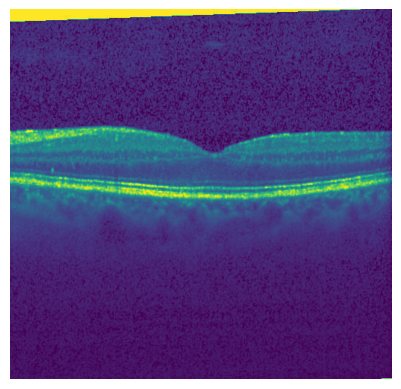

In [7]:
# Image file path
image_file = "NORMAL/NORMAL-8869683-18.jpeg"
image_path = os.path.join(train_dir, image_file)

# Read and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

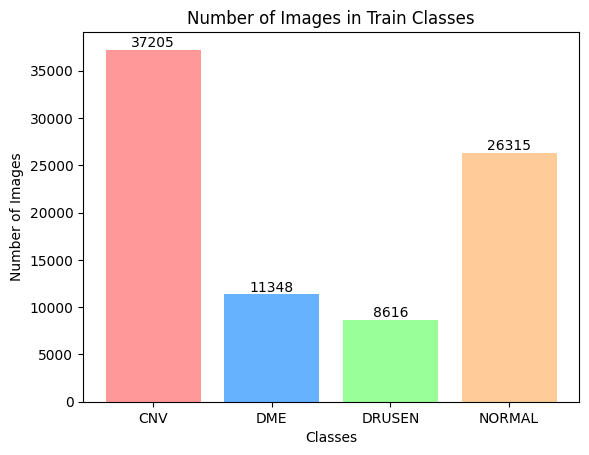

In [8]:
# Specify the directory where the dataset is located
dataset_directory = train_dir

# Create a dictionary to store the counts of images for each class
image_counts = {"CNV": 0, "DME": 0, "DRUSEN": 0, "NORMAL": 0}

# Iterate through the dataset to count the number of images for each class
for class_name in image_counts.keys():
    class_directory = os.path.join(dataset_directory, class_name)
    image_counts[class_name] = len(os.listdir(class_directory))

# Plotting the graph
classes = list(image_counts.keys())
counts = list(image_counts.values())

fig, ax = plt.subplots()
bars = ax.bar(classes, counts, color=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'])

# Display total counts above the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval), ha='center', va='bottom')

plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images in Train Classes')
plt.show()

Available per class: {'CNV': 242, 'DME': 242, 'DRUSEN': 242, 'NORMAL': 242} Total: 968
Largest feasible total: 542
Desired per class: {'CNV': 241, 'DME': 74, 'DRUSEN': 56, 'NORMAL': 171} Total: 542
✅ Created 542 files under /kaggle/working/test_ratio


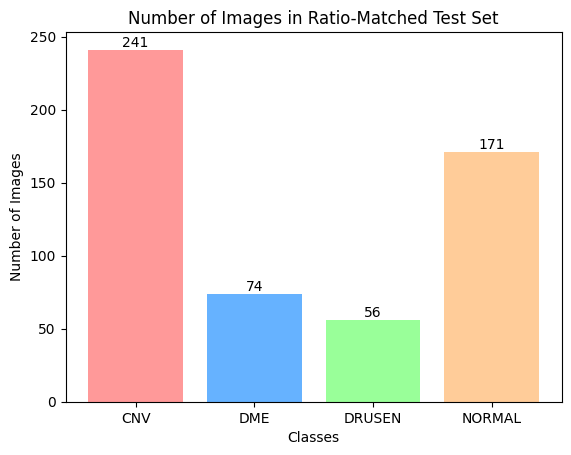

In [11]:
import os, random, math, shutil
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

random.seed(42)

# --- Directories ---
src = Path(test_dir)                         # existing test directory
dst = Path("/kaggle/working/test_ratio")     # new ratio-matched test directory

# --- Classes & Target Ratios (from your train set) ---
classes = ["CNV", "DME", "DRUSEN", "NORMAL"]
ratios  = {"CNV":0.446, "DME":0.136, "DRUSEN":0.103, "NORMAL":0.315}

# 1️⃣ Count how many images exist per class in the source
avail = {c: len(list((src/c).glob("*"))) for c in classes}
print("Available per class:", avail, "Total:", sum(avail.values()))

# 2️⃣ Compute the largest feasible total possible given class availability
feasible_total = min(math.floor(avail[c] / ratios[c]) for c in classes)
print("Largest feasible total:", feasible_total)

# 3️⃣ Compute desired samples per class based on ratios
desired = {c: int(round(ratios[c] * feasible_total)) for c in classes}
# clip by availability just in case
for c in classes:
    desired[c] = min(desired[c], avail[c])

# adjust if needed so sum matches feasible_total
diff = feasible_total - sum(desired.values())
if diff != 0:
    order = sorted(classes, key=lambda c: (avail[c]-desired[c]), reverse=True) if diff > 0 \
            else sorted(classes, key=lambda c: desired[c], reverse=True)
    i = 0
    while diff != 0 and i < len(order):
        c = order[i]
        if diff > 0 and desired[c] < avail[c]:
            desired[c] += 1; diff -= 1
        elif diff < 0 and desired[c] > 0:
            desired[c] -= 1; diff += 1
        else:
            i += 1

print("Desired per class:", desired, "Total:", sum(desired.values()))

# 4️⃣ Sample and copy files into new folder
dst.mkdir(parents=True, exist_ok=True)
rows = []
for c in classes:
    files = [p for p in (src/c).glob("*")]
    pick  = random.sample(files, desired[c])
    (dst/c).mkdir(parents=True, exist_ok=True)
    for p in pick:
        shutil.copy2(p, dst/c/p.name)
        rows.append({"filepath": str(dst/c/p.name), "label": c})

df = pd.DataFrame(rows)
print(f"✅ Created {len(df)} files under {dst}")

# 5️⃣ Plot class distribution with your color scheme
counts = dict(Counter(df["label"]))
fig, ax = plt.subplots()
bars = ax.bar(classes, [counts[c] for c in classes],
              color=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'])
for bar in bars:
    yval = int(bar.get_height())
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, yval, ha='center', va='bottom')
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images in Ratio-Matched Test Set')
plt.show()


In [13]:
import os, cv2
import numpy as np

dataset_directory = train_dir
classes = ["CNV", "DME", "DRUSEN", "NORMAL"]

TARGET_SIZE = (299, 299)  # for InceptionV3

def first_image_path(folder):
    for fname in os.listdir(folder):
        if fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")):
            return os.path.join(folder, fname)
    return None

for cls in classes:
    cls_dir = os.path.join(dataset_directory, cls)
    path = first_image_path(cls_dir)
    if path is None:
        print(f"Class: {cls}, no image files found")
        continue

    img_bgr = cv2.imread(path, cv2.IMREAD_COLOR)  # ensure 3 channels
    if img_bgr is None:
        print(f"Class: {cls}, failed to read: {path}")
        continue

    # Convert BGR->RGB for consistency with Keras/TensorFlow
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Report shapes
    orig_shape = img_rgb.shape  # (H, W, 3)
    resized = cv2.resize(img_rgb, TARGET_SIZE, interpolation=cv2.INTER_AREA)
    resized_shape = resized.shape

    print(f"Class: {cls}, Original: {orig_shape}, Resized: {resized_shape}")


Class: CNV, Original: (496, 768, 3), Resized: (299, 299, 3)
Class: DME, Original: (512, 512, 3), Resized: (299, 299, 3)
Class: DRUSEN, Original: (496, 512, 3), Resized: (299, 299, 3)
Class: NORMAL, Original: (496, 512, 3), Resized: (299, 299, 3)


In [14]:
import random
random.seed(42)
path = os.path.join(cls_dir, random.choice(os.listdir(cls_dir)))


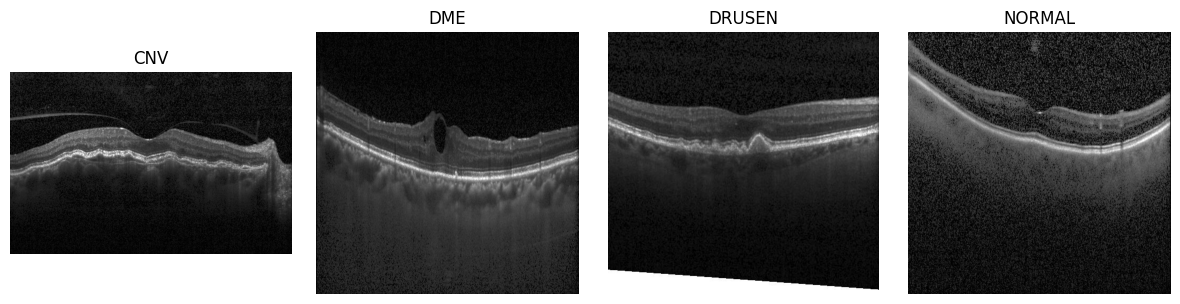

In [15]:
import os, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

random.seed(42)

classes = ["CNV", "DME", "DRUSEN", "NORMAL"]
root = Path(train_dir)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

for i, cls in enumerate(classes):
    cls_dir = root / cls
    # pick a random image file (basic extensions)
    files = [p for p in cls_dir.iterdir() if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}]
    if not files:
        axs[i].set_title(f"{cls}\n(no images)"); axs[i].axis("off"); continue
    img_path = random.choice(files)

    img = imread(img_path)

    # if grayscale, stack to RGB for consistent display
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)

    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(cls)

plt.tight_layout()
plt.show()


In [16]:
batch_size = 32


In [17]:
image_shape = (256,256,1)


In [ ]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.20, # Shift the pic width by a max of 20%
                               height_shift_range=0.15, # Shift the pic height by a max of 15%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.15, # Shear means cutting away part of the image (max 15%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [19]:
image_gen.flow_from_directory(train_dir)


Found 83484 images belonging to 4 classes.


In [20]:
image_gen.flow_from_directory(test_dir)


Found 968 images belonging to 4 classes.


In [21]:
from tensorflow.keras import Sequential, layers, regularizers

image_shape = (256, 256, 1)   # grayscale
num_classes = 4

model = Sequential([
    layers.Input(shape=image_shape),

    layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.10),

    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.15),

    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.20),

    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.20),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu',
                 kernel_initializer='he_normal',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.30),
    layers.Dense(num_classes, activation='softmax')
])


I0000 00:00:1762727660.878660     137 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [22]:
from tensorflow.keras import optimizers
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(1e-3),
              metrics=['accuracy'])


In [23]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258,692 (1010.52 KB)

 Trainable params: 257,988 (1007.77 KB)

 Non-trainable params: 704 (2.75 KB)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1)
ckpt       = ModelCheckpoint('best_cnn.h5', monitor='val_accuracy', save_best_only=True)


In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
IMG_SIZE   = (256, 256)

image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.10,
    horizontal_flip=True
)

train_image_gen = image_gen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)


Found 83484 images belonging to 4 classes.


In [27]:
val_test_gen = ImageDataGenerator(rescale=1./255)

test_image_gen = val_test_gen.flow_from_directory(
    test_dir,            # use val_dir here if you prefer a separate validation split
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 968 images belonging to 4 classes.


In [ ]:
results = model.fit(
    train_image_gen,
    epochs=10,
    validation_data=test_image_gen,
    callbacks=[early_stop, reduce_lr, ckpt],
    verbose=1
)


Epoch 1/10


I0000 00:00:1762727799.732451     235 service.cc:148] XLA service 0x7e07fc0553a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762727799.733122     235 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762727800.302595     235 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2609 ━━━━━━━━━━━━━━━━━━━━ 9:44:17 13s/step - accuracy: 0.3750 - loss: 1.3479

I0000 00:00:1762727807.901931     235 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.7527 - loss: 0.6869

2609/2609 ━━━━━━━━━━━━━━━━━━━━ 1035s 392ms/step - accuracy: 0.7527 - loss: 0.6868 - val_accuracy: 0.9432 - val_loss: 0.2056 - learning_rate: 0.0010
Epoch 2/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 533s 204ms/step - accuracy: 0.9146 - loss: 0.2668 - val_accuracy: 0.8595 - val_loss: 0.4924 - learning_rate: 0.0010
Epoch 3/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9293 - loss: 0.2208

2609/2609 ━━━━━━━━━━━━━━━━━━━━ 528s 202ms/step - accuracy: 0.9293 - loss: 0.2208 - val_accuracy: 0.9576 - val_loss: 0.1439 - learning_rate: 0.0010
Epoch 4/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 521s 200ms/step - accuracy: 0.9360 - loss: 0.1951 - val_accuracy: 0.9576 - val_loss: 0.1497 - learning_rate: 0.0010
Epoch 5/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 522s 200ms/step - accuracy: 0.9420 - loss: 0.1797 - val_accuracy: 0.9556 - val_loss: 0.1352 - learning_rate: 0.0010
Epoch 6/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9440 - loss: 0.1716

2609/2609 ━━━━━━━━━━━━━━━━━━━━ 522s 200ms/step - accuracy: 0.9440 - loss: 0.1716 - val_accuracy: 0.9804 - val_loss: 0.0776 - learning_rate: 0.0010
Epoch 7/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 518s 199ms/step - accuracy: 0.9453 - loss: 0.1696 - val_accuracy: 0.9618 - val_loss: 0.1245 - learning_rate: 0.0010
Epoch 8/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9496 - loss: 0.1584

2609/2609 ━━━━━━━━━━━━━━━━━━━━ 522s 200ms/step - accuracy: 0.9496 - loss: 0.1584 - val_accuracy: 0.9824 - val_loss: 0.0683 - learning_rate: 0.0010
Epoch 9/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 527s 202ms/step - accuracy: 0.9495 - loss: 0.1552 - val_accuracy: 0.8915 - val_loss: 0.3683 - learning_rate: 0.0010
Epoch 10/10
 142/2609 ━━━━━━━━━━━━━━━━━━━━ 8:04 197ms/step - accuracy: 0.9475 - loss: 0.1598

In [ ]:
summary = pd.DataFrame(results.history)
summary.head()


In [ ]:
results.history


In [ ]:
history_df = pd.DataFrame(results.history)
history_df.index.name = 'Epoch'
history_df.index += 1
print(history_df)


In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary['loss'],     label="loss")
plt.plot(summary['val_loss'], label="val_loss")
plt.legend(loc="upper right"); plt.ylabel("Loss"); plt.xlabel("Epoch")
plt.title("Training vs Validation Loss")
plt.show()


In [ ]:
model.evaluate(test_image_gen, verbose=1)


In [ ]:
model.metrics_names


In [ ]:
pred_probabilities = model.predict(test_image_gen, verbose=1)


In [ ]:
pred_probabilities.shape


In [ ]:
y_true = test_image_gen.classes
y_true[:10]


In [ ]:
predictions = pred_probabilities


In [ ]:
from sklearn.metrics import classification_report
y_pred = np.argmax(predictions, axis=1)
target_names = list(test_image_gen.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))


In [ ]:
model.save('CNN_model1.h5')


In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE   = (299, 299)   # InceptionV3 native size
BATCH_SIZE = 32

# Generators: scale to [0,1] only (we'll map to [-1,1] in the model)
iv3_train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.10,
    horizontal_flip=True
)
iv3_eval_aug = ImageDataGenerator(rescale=1./255)


In [53]:
iv3_train_gen = iv3_train_aug.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)


Found 83484 images belonging to 4 classes.


In [54]:
iv3_val_gen = iv3_eval_aug.flow_from_directory(
    test_dir,                    # use val_dir here if you have one
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 968 images belonging to 4 classes.


In [55]:
x_batch, y_batch = next(iv3_train_gen)
print("Batch shape:", x_batch.shape)  # expect (B, 299, 299, 1)
assert x_batch.shape[1:] == (299, 299, 1), "Generator shape is not 299x299x1 — recreate generators."


Batch shape: (32, 299, 299, 1)


In [56]:
import tensorflow as tf
from tensorflow.keras import Model, layers, optimizers
from tensorflow.keras.applications import InceptionV3

num_classes = iv3_train_gen.num_classes

inputs = layers.Input(shape=(299, 299, 1), name='gray_input')
x = layers.Concatenate(name='gray_to_rgb')([inputs, inputs, inputs])      # (299,299,3)
x = layers.Rescaling(scale=2.0, offset=-1.0, name='to_minus1_plus1')(x)   # [0,1] -> [-1,1]

base = InceptionV3(weights='imagenet', include_top=False)
base.trainable = False

x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

iv3_model = Model(inputs, outputs, name='InceptionV3_OCT')


In [57]:
iv3_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(1e-4),
    metrics=['accuracy']
)


In [58]:
iv3_model.summary()


Model: "InceptionV3_OCT"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ gray_input          │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gray_to_rgb         │ (None, 299, 299,  │          0 │ gray_input[0][0], │
│ (Concatenate)       │ 3)                │            │ gray_input[0][0], │
│                     │                   │            │ gray_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ to_minus1_plus1     │ (None, 299, 299,  │          0 │ gray_to_rgb[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_v3        │ (None, 8, 8,      │ 21,802,784 │ to_minus1_plus1[… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ inception_v3[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │      8,196 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,810,980 (83.20 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [59]:
import os
cls2idx = iv3_train_gen.class_indices
train_counts = {c: len(os.listdir(os.path.join(train_dir, c))) for c in cls2idx}
total = sum(train_counts.values())
class_weights = {cls2idx[c]: total/(len(cls2idx)*train_counts[c]) for c in cls2idx}
class_weights


{0: 0.5609729875016799,
 1: 1.8391787099048291,
 2: 2.4223537604456826,
 3: 0.7931217936538096}

In [60]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

ckpt_path = 'InceptionV3_tuning.keras'
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1)
checkpoint = ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1)
csv_log    = CSVLogger('training_log.csv', append=False)


In [61]:
history_s1 = iv3_model.fit(
    iv3_train_gen,
    validation_data=iv3_val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint, csv_log],
    verbose=1
)


Epoch 1/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.5554 - loss: 1.1021
Epoch 1: val_loss improved from inf to 0.44462, saving model to InceptionV3_tuning.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 737s 275ms/step - accuracy: 0.5554 - loss: 1.1021 - val_accuracy: 0.8802 - val_loss: 0.4446 - learning_rate: 1.0000e-04
Epoch 2/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.7246 - loss: 0.7619
Epoch 2: val_loss improved from 0.44462 to 0.34984, saving model to InceptionV3_tuning.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 663s 254ms/step - accuracy: 0.7246 - loss: 0.7619 - val_accuracy: 0.9091 - val_loss: 0.3498 - learning_rate: 1.0000e-04
Epoch 3/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.7494 - loss: 0.6990
Epoch 3: val_loss improved from 0.34984 to 0.31107, saving model to InceptionV3_tuning.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 642s 246ms/step - accuracy: 0.7494 - loss: 0.6990 - val_accuracy: 0.9194 - val_loss: 0.3111 - learning_rate: 1.0000e-04
Ep

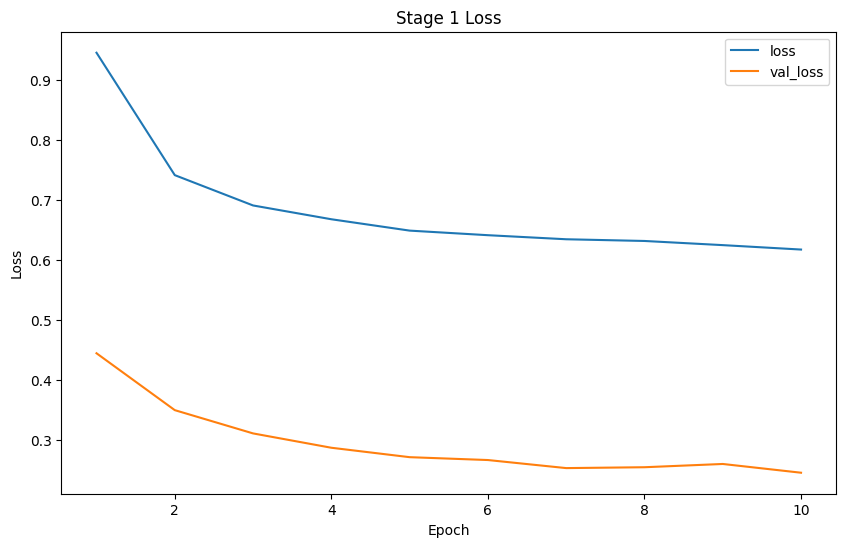

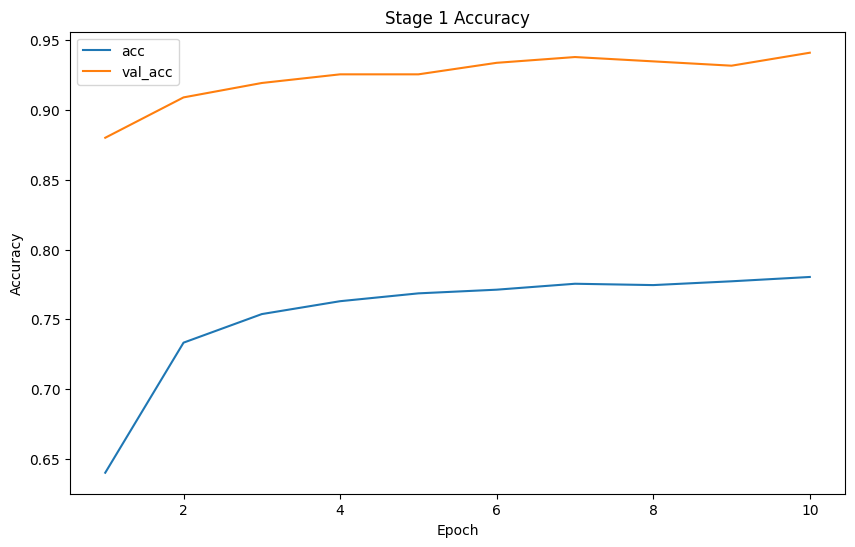

In [62]:
import pandas as pd, matplotlib.pyplot as plt

s1 = pd.DataFrame(history_s1.history); s1.index += 1

plt.figure(figsize=(10,6)); plt.plot(s1['loss'], label='loss'); plt.plot(s1['val_loss'], label='val_loss')
plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Stage 1 Loss'); plt.show()

plt.figure(figsize=(10,6)); plt.plot(s1['accuracy'], label='acc'); plt.plot(s1['val_accuracy'], label='val_acc')
plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Stage 1 Accuracy'); plt.show()


In [63]:
for layer in base.layers[-50:]:
    layer.trainable = True

iv3_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(1e-5),
    metrics=['accuracy']
)


In [64]:
history_s2 = iv3_model.fit(
    iv3_train_gen,
    validation_data=iv3_val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint, csv_log],
    verbose=1
)


Epoch 1/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.8001 - loss: 0.6170
Epoch 1: val_loss improved from 0.24557 to 0.09500, saving model to InceptionV3_tuning.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 703s 260ms/step - accuracy: 0.8002 - loss: 0.6170 - val_accuracy: 0.9762 - val_loss: 0.0950 - learning_rate: 1.0000e-05
Epoch 2/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8689 - loss: 0.3863
Epoch 2: val_loss improved from 0.09500 to 0.06184, saving model to InceptionV3_tuning.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 682s 261ms/step - accuracy: 0.8689 - loss: 0.3863 - val_accuracy: 0.9835 - val_loss: 0.0618 - learning_rate: 1.0000e-05
Epoch 3/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.8891 - loss: 0.3242
Epoch 3: val_loss improved from 0.06184 to 0.05909, saving model to InceptionV3_tuning.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 679s 260ms/step - accuracy: 0.8891 - loss: 0.3242 - val_accuracy: 0.9835 - val_loss: 0.0591 - learning_rate: 1.0000e-0

In [65]:
loss, acc = iv3_model.evaluate(iv3_val_gen, verbose=1)
print(f"Test — loss: {loss:.4f}  acc: {acc:.4f}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9897 - loss: 0.0319
Test — loss: 0.0403  acc: 0.9907


In [66]:
pred_prob = iv3_model.predict(iv3_val_gen, verbose=1)
pred_prob.shape


31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 293ms/step


(968, 4)

In [67]:
import numpy as np
from sklearn.metrics import classification_report

y_true = iv3_val_gen.classes
y_pred = np.argmax(pred_prob, axis=1)
target_names = list(iv3_val_gen.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))


              precision    recall  f1-score   support

         CNV       0.99      0.99      0.99       242
         DME       1.00      0.99      0.99       242
      DRUSEN       0.98      0.99      0.99       242
      NORMAL       1.00      0.99      0.99       242

    accuracy                           0.99       968
   macro avg       0.99      0.99      0.99       968
weighted avg       0.99      0.99      0.99       968



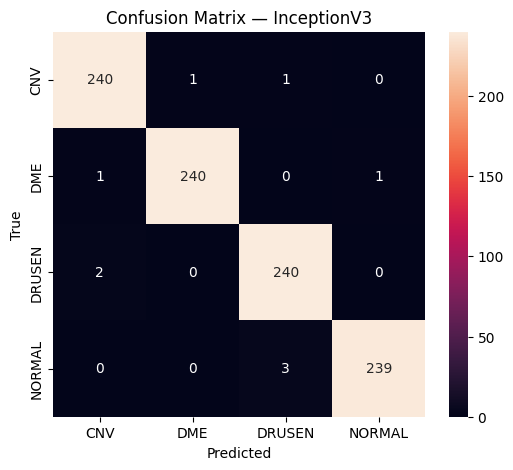

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix — InceptionV3'); plt.show()


In [69]:
iv3_model.save('InceptionV3_final.keras')


In [ ]:
# === Column 0: Fix TF/protobuf (run ONCE, before importing tensorflow) ===
!pip uninstall -y protobuf -q
!pip install -q --no-deps "protobuf==3.20.3"

import os
os.kill(os.getpid(), 9)  # hard-restart kernel so TF picks up the right protobuf


In [6]:
# === Column 1: Setup & robust OCT2017 dataset resolver ===
import os, warnings, random, zipfile, glob
from pathlib import Path
import numpy as np
import tensorflow as tf

# Quiet logs + seeds
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

print("TF:", tf.__version__)
print("Mounted roots under /kaggle/input:", [p.name for p in Path("/kaggle/input").iterdir()])

def _has_splits(p: Path):
    return all((p/s).is_dir() for s in ("train","val","test"))

def find_or_extract_oct():
    root = Path("/kaggle/input")

    # 1) Look for an OCT2017 directory anywhere under /kaggle/input
    for p in root.rglob("OCT2017"):
        if _has_splits(p):
            return p

    # 2) Fallback: find a parent that has train/val/test with OCT class folders
    for tr in root.rglob("train"):
        if all((tr/c).is_dir() for c in ("CNV","DME","DRUSEN","NORMAL")):
            parent = tr.parent
            if _has_splits(parent):
                return parent

    # 3) Last resort: extract any OCT* zip to /kaggle/working and search again
    zips = [z for z in root.rglob("*.zip") if "OCT" in z.name.upper()]
    if zips:
        out_dir = Path("/kaggle/working/oct2017_extracted")
        out_dir.mkdir(parents=True, exist_ok=True)
        print("Extracting:", zips[0])
        with zipfile.ZipFile(zips[0]) as zf:
            zf.extractall(out_dir)
        for p in out_dir.rglob("OCT2017"):
            if _has_splits(p):
                return p

    return None

oct_root = find_or_extract_oct()
assert oct_root is not None, (
    "OCT2017 not found. In the right panel, add dataset 'paultimothymooney/kermany2018'."
)

train_dir = str(oct_root / "train")
val_dir   = str(oct_root / "val")
test_dir  = str(oct_root / "test")

print("Using OCT2017 at:", str(oct_root))
for name, p in (("Train",train_dir), ("Val",val_dir), ("Test",test_dir)):
    print(f" - {name}: {p} —", "OK" if Path(p).is_dir() else "MISSING")

classes = sorted([d.name for d in Path(train_dir).iterdir() if d.is_dir()])
print("Classes:", classes)


TF: 2.18.0
Mounted roots under /kaggle/input: ['kermany2018']
Using OCT2017 at: /kaggle/input/kermany2018/OCT2017 
 - Train: /kaggle/input/kermany2018/OCT2017 /train — OK
 - Val: /kaggle/input/kermany2018/OCT2017 /val — OK
 - Test: /kaggle/input/kermany2018/OCT2017 /test — OK
Classes: ['CNV', 'DME', 'DRUSEN', 'NORMAL']


In [7]:
# === Column 2: Data generators (EffNetB3) + class weights ===
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

IMG_SIZE   = (300, 300)     # EfficientNetB3 native
BATCH_SIZE = 32

# Augment only on training; no rescale/preprocess here
train_aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.10,
    horizontal_flip=True
)
eval_aug = ImageDataGenerator()

train_gen = train_aug.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)
val_gen = eval_aug.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)
test_gen = eval_aug.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Sanity check: expect (batch, 300, 300, 3)
xb, yb = next(train_gen)
print("Train batch:", xb.shape, yb.shape)
print("Class indices:", train_gen.class_indices)

# Class weights for imbalance: total / (n_classes * count_c)
y_labels = train_gen.classes
n_cls = len(train_gen.class_indices)
counts = np.bincount(y_labels, minlength=n_cls)
class_weights = {i: (y_labels.size / (n_cls * c)) for i, c in enumerate(counts)}
print("Counts:", counts.tolist())
print("Class weights:", class_weights)


Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Train batch: (32, 300, 300, 3) (32, 4)
Class indices: {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}
Counts: [37205, 11348, 8616, 26315]
Class weights: {0: 0.5609729875016799, 1: 1.8391787099048291, 2: 2.4223537604456826, 3: 0.7931217936538096}


I0000 00:00:1763153077.974991      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EffNetB3_OCT"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 10,789,683 (41.16 MB)

 Trainable params: 10,702,380 (40.83 MB)

 Non-trainable params: 87,303 (341.03 KB)

Epoch 1/10


I0000 00:00:1763153098.867431     145 service.cc:148] XLA service 0x7b47d80025a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763153098.868265     145 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763153101.773220     145 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/2609 ━━━━━━━━━━━━━━━━━━━━ 3:52 89ms/step - accuracy: 0.2031 - loss: 1.4799   

I0000 00:00:1763153116.745545     145 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2046/2609 ━━━━━━━━━━━━━━━━━━━━ 8:06 865ms/step - accuracy: 0.7002 - loss: 0.8013

E0000 00:00:1763154894.655988     147 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763154894.868734     147 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763154895.109561     147 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763154895.322506     147 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.7133 - loss: 0.7720
Epoch 1: val_loss improved from inf to 0.14018, saving model to EffNetB3.best.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 2274s 859ms/step - accuracy: 0.7133 - loss: 0.7720 - val_accuracy: 0.9688 - val_loss: 0.1402 - learning_rate: 0.0010
Epoch 2/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.7962 - loss: 0.5741
Epoch 2: val_loss improved from 0.14018 to 0.11629, saving model to EffNetB3.best.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 1708s 655ms/step - accuracy: 0.7962 - loss: 0.5741 - val_accuracy: 0.9688 - val_loss: 0.1163 - learning_rate: 0.0010
Epoch 3/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.7969 - loss: 0.5640
Epoch 3: val_loss did not improve from 0.11629
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 1708s 655ms/step - accuracy: 0.7969 - loss: 0.5640 - val_accuracy: 0.9688 - val_loss: 0.1237 - learning_rate: 0.0010
Epoch 4/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.8029 - l

E0000 00:00:1763166481.933903     145 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763166482.136320     145 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763166482.822925     145 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763166483.041640     145 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763166483.473094     145 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

1844/2609 ━━━━━━━━━━━━━━━━━━━━ 8:36 675ms/step - accuracy: 0.8619 - loss: 0.3883

E0000 00:00:1763167754.438297     145 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763167754.636717     145 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763167755.275609     145 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763167755.497033     145 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763167755.925492     145 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.8705 - loss: 0.3662
Epoch 1: val_loss improved from 0.09664 to 0.05506, saving model to EffNetB3.best.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 1860s 692ms/step - accuracy: 0.8706 - loss: 0.3662 - val_accuracy: 0.9688 - val_loss: 0.0551 - learning_rate: 1.0000e-05
Epoch 2/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9312 - loss: 0.2097
Epoch 2: val_loss improved from 0.05506 to 0.02623, saving model to EffNetB3.best.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 1789s 685ms/step - accuracy: 0.9312 - loss: 0.2097 - val_accuracy: 0.9688 - val_loss: 0.0262 - learning_rate: 1.0000e-05
Epoch 3/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.9430 - loss: 0.1662
Epoch 3: val_loss improved from 0.02623 to 0.01668, saving model to EffNetB3.best.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 1753s 672ms/step - accuracy: 0.9430 - loss: 0.1662 - val_accuracy: 1.0000 - val_loss: 0.0167 - learning_rate: 1.0000e-05
Epoch 4/10
2609/2609 

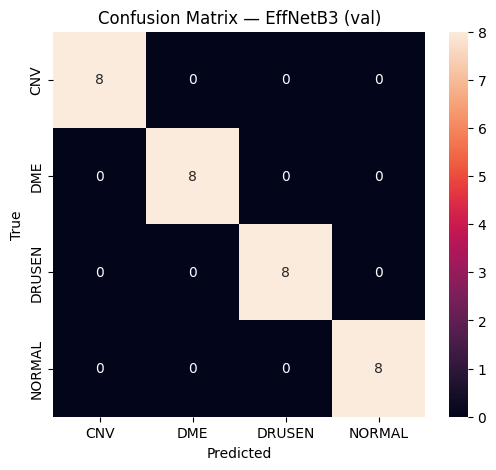

In [8]:
# === Column 3: EffNetB3 model + 2-stage training ===
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 3.1 Build model (pretrained; preprocessing is inside EfficientNetB3)
inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
base = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet', input_tensor=inputs)
x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dropout(0.30)(x)
outputs = layers.Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs, outputs, name="EffNetB3_OCT")
model.summary()

# 3.2 Callbacks
ckpt = ModelCheckpoint('EffNetB3.best.keras', monitor='val_loss', save_best_only=True, verbose=1)
early = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
rlr  = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.3, verbose=1)
csv  = CSVLogger('training.log.csv', append=False)

# 3.3 Stage 1: freeze backbone, train head
for l in base.layers:  # freeze all
    l.trainable = False

model.compile(optimizer=optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_s1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early, rlr, ckpt, csv],
    verbose=1
)

# 3.4 Stage 2: fine-tune top layers (keep BatchNorm frozen)
for l in base.layers:
    if isinstance(l, tf.keras.layers.BatchNormalization):
        l.trainable = False
for l in base.layers[-200:]:
    if not isinstance(l, tf.keras.layers.BatchNormalization):
        l.trainable = True

model.compile(optimizer=optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_s2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early, rlr, ckpt],
    verbose=1
)

# 3.5 Evaluate and report
val_loss, val_acc   = model.evaluate(val_gen, verbose=1)
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Val  : loss={val_loss:.4f} acc={val_acc:.4f}")
print(f"Test : loss={test_loss:.4f} acc={test_acc:.4f}")

# 3.6 Classification report + confusion matrix on VAL
pred_prob = model.predict(val_gen, verbose=1)
y_true = val_gen.classes
y_pred = pred_prob.argmax(axis=1)
target_names = list(val_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — EffNetB3 (val)")
plt.show()

# 3.7 Save final model
model.save('EffNetB3.final.keras')


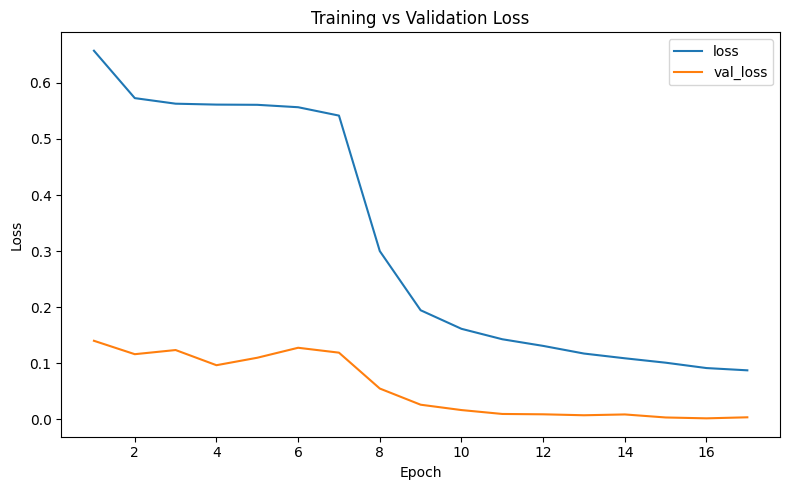

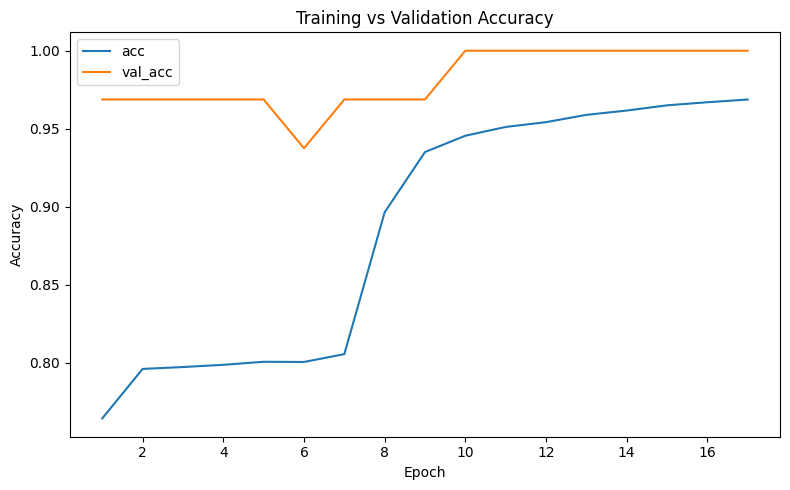

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 1.0000 - loss: 0.0019
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.9983 - loss: 0.0069
VAL  -> loss 0.0019  acc 1.0000
TEST -> loss 0.0127  acc 0.9969
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 404ms/step
              precision    recall  f1-score   support

         CNV       1.00      1.00      1.00       242
         DME       1.00      1.00      1.00       242
      DRUSEN       0.99      1.00      1.00       242
      NORMAL       1.00      0.99      1.00       242

    accuracy                           1.00       968
   macro avg       1.00      1.00      1.00       968
weighted avg       1.00      1.00      1.00       968



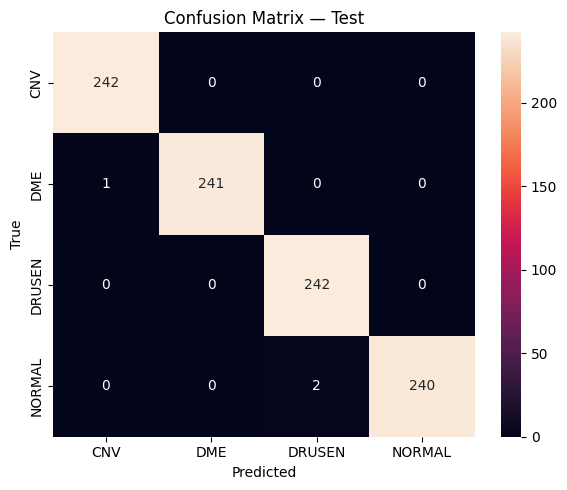

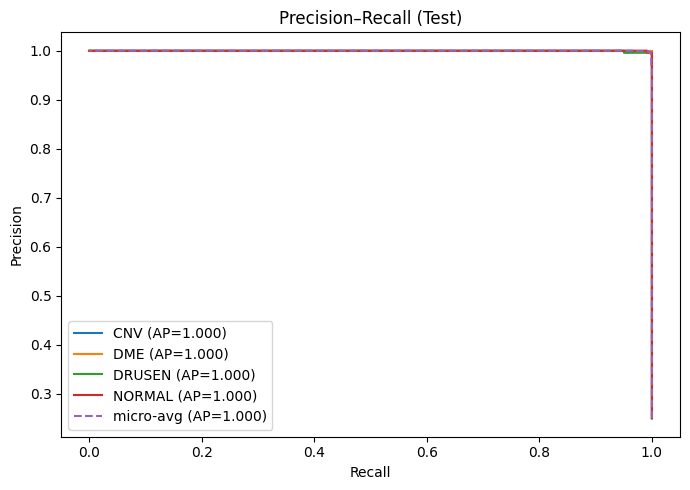

Per-class AP: {'CNV': 0.9999999999999999, 'DME': 0.9999999999999999, 'DRUSEN': 0.9997911694452273, 'NORMAL': 0.9999659195961057}
Micro-avg AP: 1.000


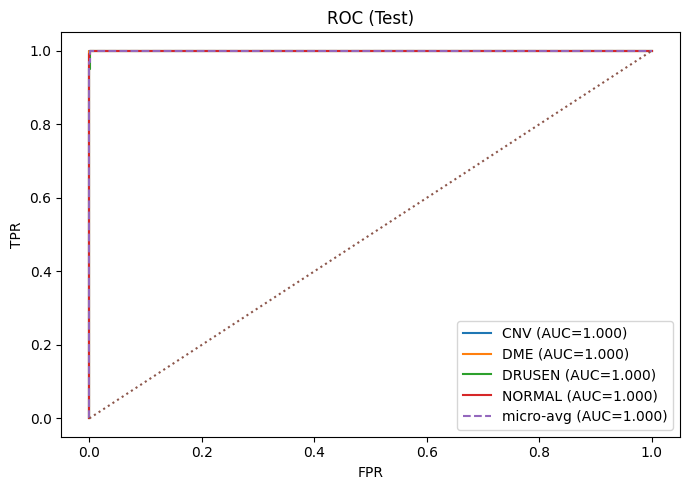

Per-class AUC: {'CNV': 1.0, 'DME': 1.0, 'DRUSEN': 0.9999316986544635, 'NORMAL': 0.9999886164424107}
Micro-avg AUC: 1.000


In [9]:
# === Column 4: Learning curves + PR/ROC + Test report ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_recall_curve, average_precision_score,
                             roc_curve, auc)
from sklearn.preprocessing import label_binarize
from pathlib import Path

Path("/kaggle/working").mkdir(parents=True, exist_ok=True)

# 4.1 Combine histories and plot
def combine_histories(h1, h2):
    df1 = pd.DataFrame(h1.history)[["loss","val_loss","accuracy","val_accuracy"]]; df1.index += 1
    df2 = pd.DataFrame(h2.history)[["loss","val_loss","accuracy","val_accuracy"]]; df2.index += len(df1) + 1
    return pd.concat([df1, df2], axis=0)

hist_df = combine_histories(history_s1, history_s2)
hist_df.to_csv("/kaggle/working/history_combined.csv")

plt.figure(figsize=(8,5))
plt.plot(hist_df.index, hist_df["loss"], label="loss")
plt.plot(hist_df.index, hist_df["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss")
plt.legend(); plt.tight_layout(); plt.savefig("/kaggle/working/curve_loss.png"); plt.show()

plt.figure(figsize=(8,5))
plt.plot(hist_df.index, hist_df["accuracy"], label="acc")
plt.plot(hist_df.index, hist_df["val_accuracy"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Training vs Validation Accuracy")
plt.legend(); plt.tight_layout(); plt.savefig("/kaggle/working/curve_accuracy.png"); plt.show()

# 4.2 Evaluate on VAL and TEST
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"VAL  -> loss {val_loss:.4f}  acc {val_acc:.4f}")
print(f"TEST -> loss {test_loss:.4f}  acc {test_acc:.4f}")

# 4.3 Reports + Confusion Matrix (TEST)
pred_prob_test = model.predict(test_gen, verbose=1)
y_true_test = test_gen.classes
y_pred_test = pred_prob_test.argmax(axis=1)
target_names = list(test_gen.class_indices.keys())

print(classification_report(y_true_test, y_pred_test, target_names=target_names))

cm = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — Test")
plt.tight_layout(); plt.savefig("/kaggle/working/cm_test.png"); plt.show()

# 4.4 Precision–Recall curves (TEST)
n_classes = len(target_names)
y_true_bin = label_binarize(y_true_test, classes=list(range(n_classes)))

plt.figure(figsize=(7,5))
aps = []
for i, name in enumerate(target_names):
    pr, rc, _ = precision_recall_curve(y_true_bin[:, i], pred_prob_test[:, i])
    ap = average_precision_score(y_true_bin[:, i], pred_prob_test[:, i])
    aps.append(ap)
    plt.plot(rc, pr, label=f"{name} (AP={ap:.3f})")
# micro-average
pr_micro, rc_micro, _ = precision_recall_curve(y_true_bin.ravel(), pred_prob_test.ravel())
ap_micro = average_precision_score(y_true_bin, pred_prob_test, average="micro")
plt.plot(rc_micro, pr_micro, linestyle="--", label=f"micro-avg (AP={ap_micro:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall (Test)")
plt.legend(); plt.tight_layout(); plt.savefig("/kaggle/working/pr_curves.png"); plt.show()
print(f"Per-class AP: {dict(zip(target_names, [float(a) for a in aps]))}")
print(f"Micro-avg AP: {ap_micro:.3f}")

# 4.5 ROC curves (TEST)
plt.figure(figsize=(7,5))
aucs = []
for i, name in enumerate(target_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], pred_prob_test[:, i])
    roc_auc = auc(fpr, tpr); aucs.append(roc_auc)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
# micro-average
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), pred_prob_test.ravel())
auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, linestyle="--", label=f"micro-avg (AUC={auc_micro:.3f})")
plt.plot([0,1],[0,1], linestyle=":")  # chance
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (Test)")
plt.legend(); plt.tight_layout(); plt.savefig("/kaggle/working/roc_curves.png"); plt.show()
print(f"Per-class AUC: {dict(zip(target_names, [float(a) for a in aucs]))}")
print(f"Micro-avg AUC: {auc_micro:.3f}")
